In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [4]:
from freq_domain import plotspec
from wavegen import cosine_wave

from transmitter import pulse_shaped

## 10.1 Estimation Using FFT

In [5]:
N = 10000 # num symbols
M = 20 # oversampling factor
Ts = 0.0001 # sampling frequency

fc = 1000 # Carrier frequency
phi = -1  # Phase offset

In [6]:
duration = Ts*M*N
t, carrier = cosine_wave(fc, duration, Ts, phi)

In [7]:
symbols = np.random.choice([-3, -1, 1, 3], N) # 4-PAM
waveform = pulse_shaped(symbols, M)
modulated_suppr_carrier = waveform * carrier
modulated_large_carrier = (1 + waveform) * carrier

### Large carrier

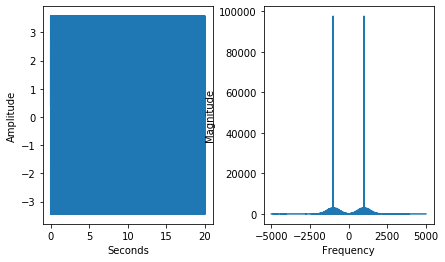

In [8]:
plotspec(modulated_large_carrier, Ts);

In [9]:
fft_lc = fft(modulated_large_carrier)
max_idx = np.argmax(fft_lc[:len(fft_lc)//2])
Fs = 1/Ts
freq_range = Fs*np.arange(0, N*M//2)/(N*M)
freq_at_max = freq_range[max_idx]
phase_at_max = np.angle(fft_lc[max_idx])
print(f'Estimated carrier freq = {freq_at_max}, Actual carrier freq = {fc}')
print(f'Estimated carrier pahse = {phase_at_max:.2f}, Actual carrier phae = {phi}')

Estimated carrier freq = 1000.0, Actual carrier freq = 1000
Estimated carrier pahse = -1.00, Actual carrier phae = -1


### Suppressed Carrier

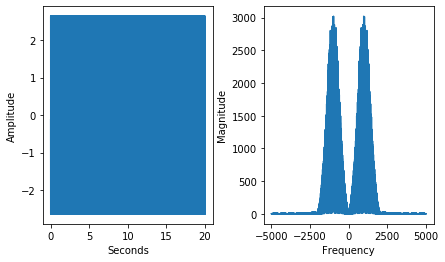

In [10]:
plotspec(modulated_suppr_carrier, Ts);

In [11]:
# Above method does not work with suppressed carrier
# Remember that even a 0.01 frequency offset can be catastrophic
fft_sc = fft(modulated_suppr_carrier)
max_idx = np.argmax(fft_sc[:len(fft_sc)//2])
Fs = 1/Ts
freq_range = Fs*np.arange(0, N*M//2)/(N*M)
freq_at_max = freq_range[max_idx]
phase_at_max = np.angle(fft_sc[max_idx])
print(f'Estimated carrier freq = {freq_at_max}, Actual carrier freq = {fc}')
print(f'Estimated carrier pahse = {phase_at_max:.2f}, Actual carrier phae = {phi}')

Estimated carrier freq = 923.1, Actual carrier freq = 1000
Estimated carrier pahse = 0.24, Actual carrier phae = -1


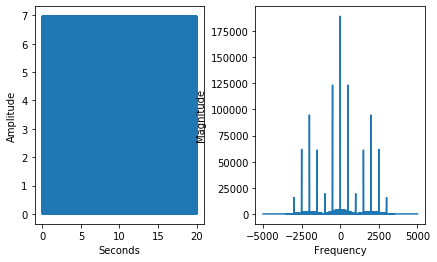

In [12]:
# Spectrum with a square non-linearity
plotspec(modulated_suppr_carrier**2, Ts);

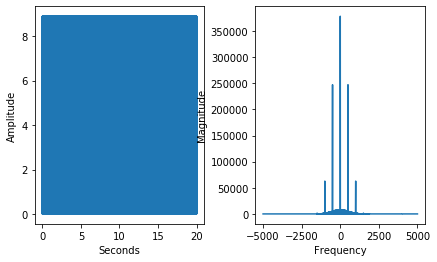

In [13]:
# The DC component is the non-zero average of the squared waveform.
# The spike at 500 Hz is because the symbol is generated by a square wave
# with symbol period = Ts * M = 0.002 secs, or freq = 500 Hz
plotspec(waveform**2, Ts);

In [14]:
squared_signal = modulated_suppr_carrier ** 2 # Use a square non-linearity
# Create bandpass filter at twice the carrier frequency
taps = 500
Fs = 1/Ts
band_edges = [0, 1900, 1950, 2050, 2100, 5000]
damps = [0, 1, 0]
b = signal.remez(taps, band_edges, damps, fs=Fs)
preprocessed = signal.lfilter(b, 1, squared_signal)

In [15]:
# Now use the fft method
fft_preprocessed = fft(preprocessed)
max_idx = np.argmax(fft_preprocessed[:len(fft_preprocessed)//2])
Fs = 1/Ts
freq_range = Fs*np.arange(0, N*M//2)/(N*M)
freq_at_max = freq_range[max_idx]
phase_at_max = np.angle(fft_preprocessed[max_idx])
print(f'Estimated carrier freq = {freq_at_max//2}, Actual carrier freq = {fc}')
print(f'Estimated carrier pahse = {phase_at_max//2:.2f}, Actual carrier phae = {phi}')

Estimated carrier freq = 1000.0, Actual carrier freq = 1000
Estimated carrier pahse = -1.00, Actual carrier phae = -1
